In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
from openpyxl import load_workbook

pd.set_option('display.max_columns', None)

/tmp/ipykernel_52196/3799527895.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [34]:
nr_sheets_CZ = len(pd.ExcelFile('../raw_data/FLYBALLCZ_versenyadatok.xlsx').sheet_names)
nr_sheets_EFC = len(pd.ExcelFile('../raw_data/EFC_versenyadatok.xlsx').sheet_names)
nr_sheets_CZ, nr_sheets_EFC

(12, 4)

In [78]:
def worksheet_to_df(file, sheet_nr):
    col_names = [
        'division', 'when', 'team1', 'team2', 'time_tot', 'win', 'hurdles',
        'name1', 'start_chng1', 'time1', 
        'name2', 'start_chng2', 'time2', 
        'name3', 'start_chng3', 'time3', 
        'name4', 'start_chng4', 'time4'
    ]
    months = {
        'április': 'april',
        'május': 'may',
        'június': 'june',
        'július': 'july',
        'augusztus': 'august',
        'szeptember': 'september',
        'október': 'october'
    }
    df = pd.read_excel(file, sheet_name=sheet_nr, header=1, index_col=0)
    df.columns = col_names
    df.when = df.when.apply(lambda x: x.time() if type(x) == pd._libs.tslibs.timestamps.Timestamp else x) # convert Timestamp to datetime.time
    df.when = pd.to_datetime(df.when.apply(lambda x: datetime.datetime.combine(datetime.date(2023, 1, 1), x) if type(x) != float else None))  # I need a dummy date to be able to use the diff fucntion later
    
    event_and_date = pd.read_excel(file, sheet_name=sheet_nr, header=None).iloc[0,1]
    df['event'] = event_and_date.split('2023')[0].strip()
    month = months[event_and_date.split('2023.')[1].strip().split()[0].strip()]
    days = event_and_date.split()[-1].rstrip('.')
    df['month'] = month
    df['day1'] = days.split('-')[0] if '-' in days else days
    df['day2'] = days.split('-')[1] if '-' in days else None
    df['newday'] = df.when.diff().dt.total_seconds().fillna(0).astype(int) < 0
    df['newday'] = df['newday'].cummax().astype(bool)
    df['day'] = np.where(df['newday'], df['day2'], df['day1'])
    df['date'] = pd.to_datetime(df['month'] + ' ' + df['day'] + ', 2023', format='%B %d, %Y')
    df['when'] = pd.to_datetime(df['date'].dt.date.astype(str) + ' ' + df['when'].dt.time.astype(str))
    df = df.drop(['month', 'day1', 'day2', 'newday', 'day', 'date'], axis=1)

    wb = load_workbook(file)
    sheet = wb[wb.sheetnames[sheet_nr]]
    text_colors = []
    for cell in sheet['D3':f'D{sheet.max_row}']:
        if cell[0].value:
            text_colors.append(cell[0].font.color.rgb if type(cell[0].font.color.rgb) == str else None)

    df = df.dropna(subset=['team1'])
    df['course_color'] = text_colors
    df['course_color'] = df['course_color'].replace({
        'FFFF0000': 'red', 
        'FF0000FF': 'blue'
    })

    return df

In [79]:
df_list = []

for i in range(nr_sheets_CZ):
    df_list.append(worksheet_to_df('../raw_data/FLYBALLCZ_versenyadatok.xlsx', i))

for i in range(nr_sheets_EFC):
    df_list.append(worksheet_to_df('../raw_data/EFC_versenyadatok.xlsx', i))

df = pd.concat(df_list, axis=0)
print(df.shape)

df.head()

(8571, 21)


,division,when,team1,team2,time_tot,win,hurdles,name1,start_chng1,time1,name2,start_chng2,time2,name3,start_chng3,time3,name4,start_chng4,time4,event,course_color
1,1,2023-04-22 10:11:57,WildRunners dreamers,WildRunners Maximini,17.01,P,25.0,Sunny,-0.24,4.21,Dixie,0.3,4.24,Alex,0.16,4.22,Hector,ok,4.13,Hanácké škvarek (Heroltice),blue
2,1,2023-04-22 10:11:57,WildRunners Maximini,WildRunners dreamers,19.43,P,25.0,Brooke,-0.11,4.08,Rocky,1.29,5.15,Bella,0.23,4.52,Bree,OK,4.28,Hanácké škvarek (Heroltice),red
3,1,2023-04-22 10:13:25,WildRunners dreamers,WildRunners Maximini,17.42,V,25.0,Sunny,0.02,4.25,Dixie,0.15,4.23,Alex,0.34,4.25,Hector,OK,4.18,Hanácké škvarek (Heroltice),blue
4,1,2023-04-22 10:13:25,WildRunners Maximini,WildRunners dreamers,18.59,P,25.0,Brooke,-0.63,4.25,Rocky,0.79,5.5,Bella,0.16,4.56,Bree,-0.33,4.28,Hanácké škvarek (Heroltice),red
5,1,2023-04-22 10:15:06,WildRunners dreamers,WildRunners Maximini,16.73,V,25.0,Sunny,-0.06,4.21,Dixie,-0.19,4.29,Alex,0.12,4.27,Hector,chyba,4.08,Hanácké škvarek (Heroltice),blue


## Data processing

- Runs where time3 or time4 is NaN are dropped
- division is stored as an integer
- Timestamp objects in when column are converted to datetime.datetime
- Some dog names were 0, they are replaced by NaN, finally all NaNs are replaced with 'unknown'
- Dropped the rows where all 4 dog names are unknown

- Czech win/loss/tie letters are mapped to their English equivalents
- OK and variants are replaced with zero
- Czech terms (chyba, vběhl, mimo) are replaced with their English equivalents

In [24]:
ok_mapping = {
    'ok': 0.0,
    'OK': 0.0,
    'Ok': 0.0
}

text_mapping = {
    'chyba': 'error',
    'vběhl': 'run in',
    'mimo': 'outside',
    'V': 'W',
    'P': 'L',
    'R': 'T'
}

df = df.dropna(subset=['time3', 'time4'])
df.division = df.division.astype(int)
#df.when = df.when.apply(lambda x: x.time() if type(x) == pd._libs.tslibs.timestamps.Timestamp else x) # convert Timestamp to datetime.time
#df.when = pd.to_datetime(df.when.apply(lambda x: datetime.datetime.combine(datetime.date(2020, 1, 1), x)))  # I need a dummy date for plotting, which can be updated later to the real dates if needed
df.win = df.win.fillna('NA')

df[['name1', 'name2', 'name3', 'name4']] = df[['name1', 'name2', 'name3', 'name4']].replace(0, np.nan)
df = df[df.name1.isnull() & df.name2.isnull() & df.name3.isnull() & df.name4.isnull() == False] # drop rows where all names are NaN
df[['name1', 'name2', 'name3', 'name4']] = df[['name1', 'name2', 'name3', 'name4']].fillna('unknown')

df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']] = \
    df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']].replace(ok_mapping)

df[['win', 'time1', 'time2', 'time3', 'time4', 'start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']] = \
    df[['win', 'time1', 'time2', 'time3', 'time4', 'start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']].replace(text_mapping) 

# Wrong start and wrong change will be replaced with -1

df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']] = \
    df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']].replace('run in', -1) # run in shold belong to run time. It is a mistake if it is in the change time

df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']] = \
    df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']].fillna(-1) 

df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']] = \
    df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']].replace('error', -1)

df.shape

/tmp/ipykernel_33862/1339654959.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['start_chng1', 'start_chng2', 'start_chng3', 'start_chng4']].replace('error', -1)


(8283, 21)

In [25]:
# When hurdle height is missing, it is substituted with the average of the same team
hurdle_substitution = {}

def substitute_hurdles(team):
    unique_hurdles = df[df.team1 == team].hurdles.unique()
    unique_hurdles = unique_hurdles[~pd.isnull(unique_hurdles)]
    return unique_hurdles.mean()

for team in df[df.hurdles.isnull()].team1.unique():
    hurdle_substitution[team] = substitute_hurdles(team)

df.hurdles = df.hurdles.fillna(df.team1.map(hurdle_substitution))

In [26]:
df['time1'] = pd.to_numeric(df['time1'], errors='coerce')  # coerce: NaN, ignore: original input
df['time2'] = pd.to_numeric(df['time2'], errors='coerce')
df['time3'] = pd.to_numeric(df['time3'], errors='coerce')
df['time4'] = pd.to_numeric(df['time4'], errors='coerce')

df['start_chng1'] = pd.to_numeric(df['start_chng1'], errors='coerce')
df['start_chng2'] = pd.to_numeric(df['start_chng2'], errors='coerce')
df['start_chng3'] = pd.to_numeric(df['start_chng3'], errors='coerce')
df['start_chng4'] = pd.to_numeric(df['start_chng4'], errors='coerce')


In [27]:
df.isnull().sum()

division           0
when               0
team1              0
team2              0
time_tot           0
win                0
hurdles            0
name1              0
start_chng1        0
time1             95
name2              0
start_chng2        0
time2            108
name3              0
start_chng3        0
time3            111
name4              0
start_chng4        0
time4            166
event              0
course_color    1134
dtype: int64

In [28]:
df.shape

(8283, 21)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8283 entries, 1.0 to 345.0
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   division      8283 non-null   int64         
 1   when          8283 non-null   datetime64[ns]
 2   team1         8283 non-null   object        
 3   team2         8283 non-null   object        
 4   time_tot      8283 non-null   float64       
 5   win           8283 non-null   object        
 6   hurdles       8283 non-null   float64       
 7   name1         8283 non-null   object        
 8   start_chng1   8283 non-null   float64       
 9   time1         8188 non-null   float64       
 10  name2         8283 non-null   object        
 11  start_chng2   8283 non-null   float64       
 12  time2         8175 non-null   float64       
 13  name3         8283 non-null   object        
 14  start_chng3   8283 non-null   float64       
 15  time3         8172 non-null   float64   

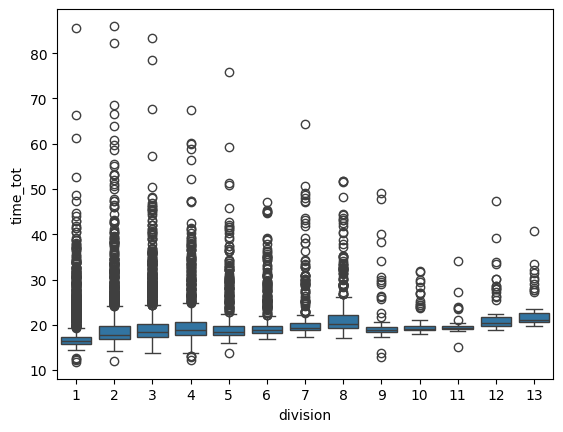

In [30]:
# I do not care about the outliers for now
sns.boxplot(y='time_tot', x='division', data=df);

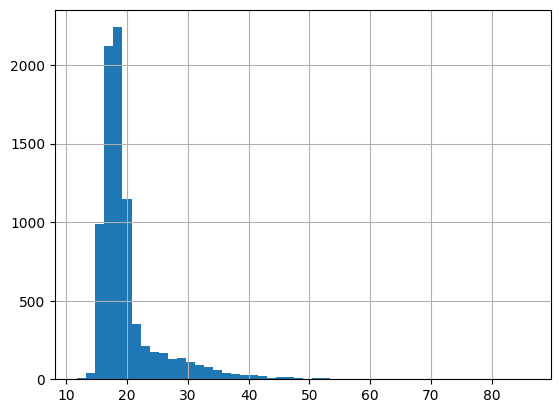

In [31]:
df.time_tot.hist(bins=50);

count                             8283
mean     2020-01-01 13:02:45.280091648
min                2020-01-01 08:04:02
25%         2020-01-01 10:47:04.500000
50%                2020-01-01 12:59:42
75%                2020-01-01 15:13:14
max                2020-01-01 18:55:29
Name: when, dtype: object


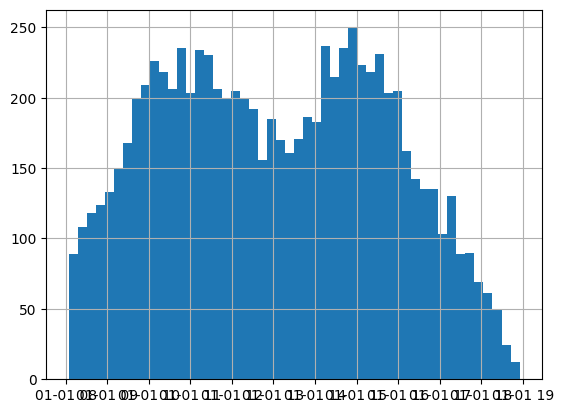

In [32]:
print(df.when.describe())
df.when.hist(bins=50);

Group 1
Unknown names: 10
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)




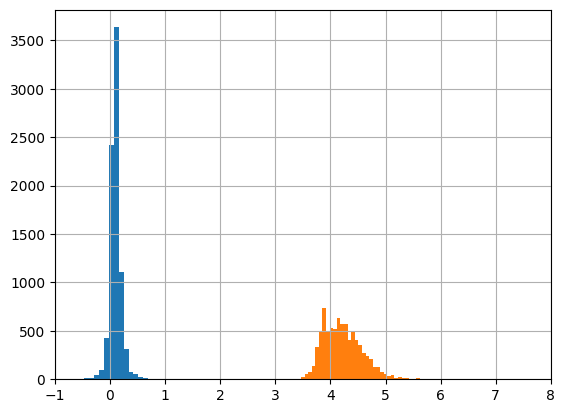

Group 2
Unknown names: 8
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)




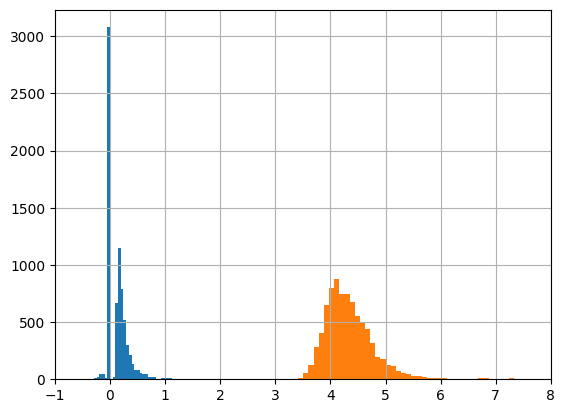

Group 3
Unknown names: 4
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)




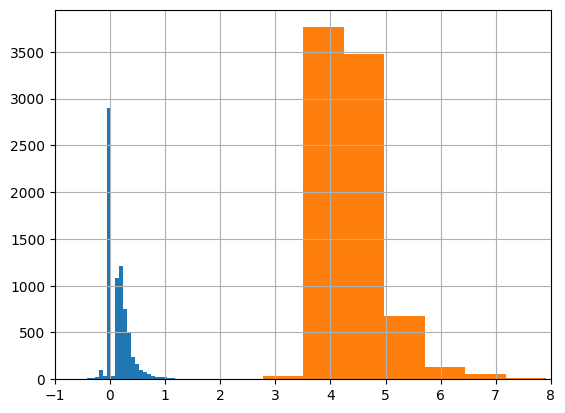

Group 4
Unknown names: 16
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)




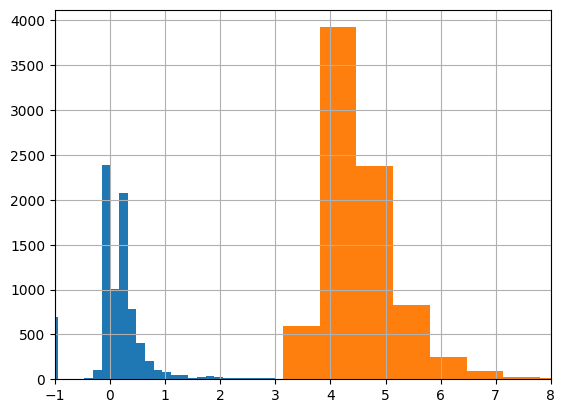

In [52]:
for i in range(1,5):
    plt.figure(i)
    plt.xlim([-1, 8])
    print(f'Group {i}')
    print(f"Unknown names: {sum(df['name' + str(i)] == 'unknown')}")

    df['start_chng' + str(i)][df['start_chng' + str(i)].apply(type) == float].hist(bins=300)
    print(df['start_chng' + str(i)][df['start_chng' + str(i)].apply(type) == str].value_counts())

    df['time' + str(i)][df['time' + str(i)].apply(type) == float].hist(bins=100)    
    print(df['time' + str(i)][df['time' + str(i)].apply(type) == str].value_counts())
    print('\n')

    plt.show()

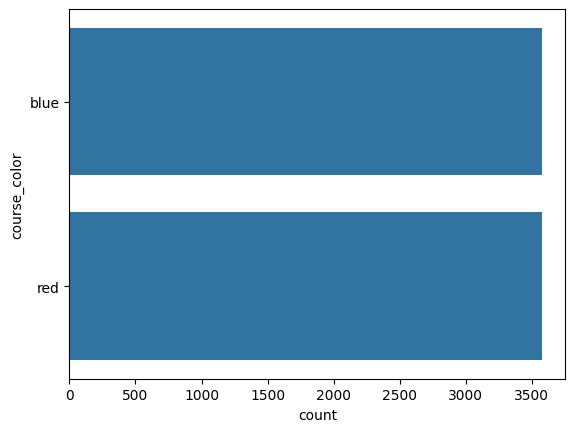

In [34]:
sns.countplot(df['course_color']);

In [35]:
df['course_color'].value_counts()

course_color
red     3575
blue    3574
Name: count, dtype: int64

In [36]:
df.to_csv('../races.csv', index=False)